# Dynamical Length evolution

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In this notebook we investigate the dynamics of length evolution. We have to consider that the probability of removing a position from a site depends more strongly on the state of the site than when adding a position, since adapted sites have more specific positions which are beneficial to the interaction with the binding molecule.

First we import necessary packages and set the plotting style. (If default plotting style is wanted, `Jedi.jl` does not need to be imported.)

In [1]:
using Plots, Measures, LambertW, CSV, DataFrames, Statistics, LaTeXStrings, JLD, Printf

# Custom Packages
using Jedi, Jevo

# Set plotting style
Jedi.default_gr!()

┌ Info: Precompiling Jedi [b681c197-c997-42fd-b5bb-d7d7839f617e]
└ @ Base loading.jl:1278


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13739389272503955257\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-8888023734361446913\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13739389272503955257\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.GRBackend()

First we set the parameters and initiate the fitness landscape.

In [2]:
N = 100
f0 = 150/2N
ϵ = 1
n = 4
κ = 0


F = Jevo.fermi_fitness(f0=f0, fl=0, epsilon=ϵ);
F0 = Jevo.fermi_fitness(f0=f0,  fl=0, epsilon=ϵ);
# Length scale
l0(n, F) = 1/F.epsilon * lambertw(2 * F.epsilon^2 * N * 10 * F.f0 * (n-1)/n^2* exp(5 * F.epsilon))
l0(κ, l, n, F) = 1/F.epsilon * lambertw(2 * F.epsilon^2 * N * l * F.f0 * (n-1)/n^2 * exp(5 * F.epsilon)/(1 + κ))

# Find length cost to set length in equilibrium (derived from genetic load modified by length dynamics)
lambda(l_opt, n, F) = l0(n, F)^2 / l_opt^2 * n^2 / (n-1) * 1/F.epsilon
lambda_new(l_opt, n, F) = l0(n, F)^3 / l_opt^2 * n^2 / (n-1) * 1/2
lambda_new(l_opt, κ, l, n, F) = l0(κ, l, n, F)^3 / l_opt^2 * n^2 / (n-1) * 1/2

#l_opt_static(κ, ϵ, n) = l0(ϵ, n) * sqrt(n^2 / ((n - 1) * ϵ * lambda(10)) * (1+κ))
l_opt_dynamic(κ, n, F) = l0(n, F)^(3/2) * sqrt(n^2 / ((n - 1) * 2 * lambda_new(10, n, F)) * (1+κ))

l_opt_dynamic (generic function with 1 method)

Use function to compute predicted mutation selection balance. The derivation can be found in Supplementary methods 3.

In [3]:
function theoretical_msb(κ, F, n, l_arr::Array{Int64, 1}=collect(8:40))
    l_0 = [l0(κ, l, n, F) for l in l_arr]
    k_msb = -l_0  .+ (l_arr .* ((n-1)/n))
    return F.epsilon * k_msb
end


function theoretical_load(κ, F, l_arr::Array{Int64, 1}=collect(8:40))
    Load = zeros(length(l_arr))
    for (j, l) in enumerate(l_arr)
        Load[j] = 1/F.epsilon * (1+κ) * n^2/(n-1) * l0(n, F)/l + 2N * F.fl * l
    end
    lopt = l0(n, F) * sqrt(n^2/(F.epsilon * (n-1) * (2N *F.fl*l0(n, F))) * (1 + κ))
    return Load, lopt
end

function theoretical_load_dynamic(κ, F, l_arr::Array{Int64, 1}=collect(8:40))
    Load = zeros(length(l_arr))
    for (j, l) in enumerate(l_arr)
        Load[j] = 1/2 * (1+κ) * n^2/(n-1) * l0(n, F)^2/l + 2N * F.fl * l
    end
    lopt = l0(n, F)^(3/2) * sqrt(n^2/(2 * (n-1) * 2N *F.fl*l0(n, F)) * (1 + κ))
    return Load, lopt
end

theoretical_load_dynamic (generic function with 2 methods)

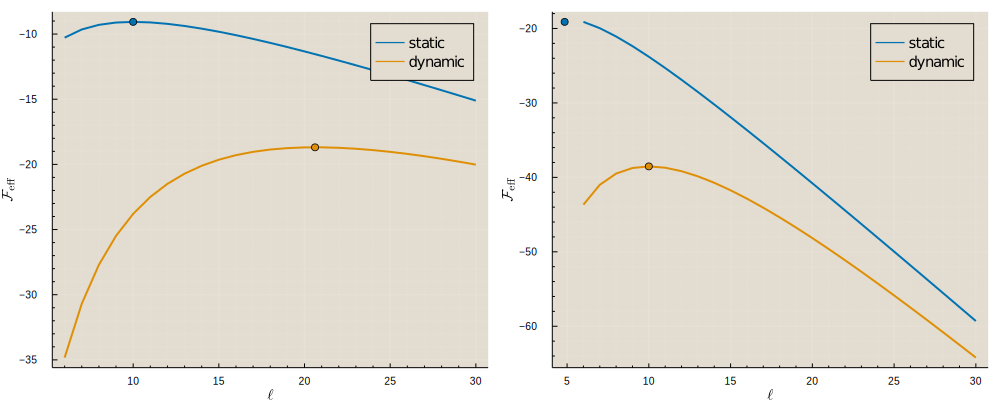

In [15]:
F.fl = lambda(10, n, F)/(2N*l0(n, F))
F.fl = lambda_new(10, n, F)/(2N*l0(n, F))
p_arr = []

for F.fl in [lambda(10, n, F)/(2N*l0(n, F)), lambda_new(10, n, F)/(2N*l0(n, F))]
    l_arr = collect(6:30)
    p = plot(
        legendfontsize=10, 
        labelfontsize=10,
        ticktfontsize=10,
        xlabel=L"$\ell$",
        ylabel=L"$\mathcal{F}_\mathrm{eff}$",
        xminorticks=true,
        yminorticks=true,
        minorgrid=true,
        minorgridcolor="white",
        legend=:topright
    )

    y1 = theoretical_load(0, F, l_arr)
    
    y2 = theoretical_load_dynamic(0, F, l_arr)
    plot!(
        p,
        l_arr, 
        -y1[1], 
        label="static",
        linewidth=2,
        color=palette(:seaborn_colorblind)[1]
    )

    scatter!(
        p,
        [y1[2]], 
        [maximum(-y1[1])],
        color=palette(:seaborn_colorblind)[1]
    )

    plot!(
        p,
        l_arr, 
        -y2[1],
        label="dynamic", 
        linewidth=2,
        color=palette(:seaborn_colorblind)[2]
    )

    scatter!(
        p,
        [y2[2]], 
        [maximum(-y2[1])],
        color=palette(:seaborn_colorblind)[2]
    )
    push!(p_arr, p)
end
plot(p_arr..., size=(1000, 400))

### Selection Coefficient

First we take a look at the selection coefficients for length increase and decrease mutation.

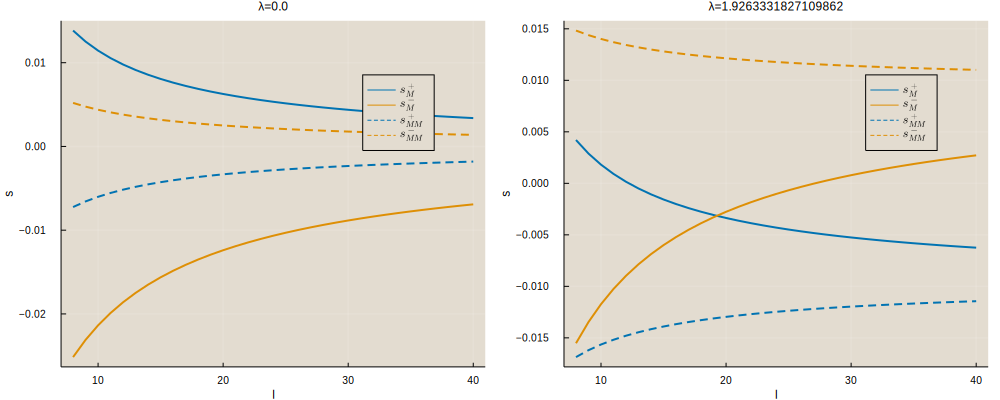

In [16]:
l = collect(8:40)
p_list = []
for F in [F0, F]

    k = theoretical_msb(0, F, n, l)
    s_plus_match = Jevo.fitness.(k, l .+ 1, F) .- Jevo.fitness.(k, l, F)
    s_plus_mismatch = Jevo.fitness.(k .+ F.epsilon, l .+ 1, F) .- Jevo.fitness.(k, l, F)


    k = theoretical_msb(0, F, n, l .+ 1)
    s_minus_match = Jevo.fitness.(k, l, F) .- Jevo.fitness.(k, l .+ 1, F)
    s_minus_mismatch = Jevo.fitness.(k .- F.epsilon, l, F) .- Jevo.fitness.(k, l .+ 1, F)


    p = plot(
        l, 
        s_plus_match, 
        label=L"$s_M^+$",
        ylabel="s",
        xlabel="l",
        linewidth=2,
        color=palette(:seaborn_colorblind)[1],
        title="λ=$(F.fl * 2N)"
    )

    plot!(
        l, 
        s_minus_match, 
        label=L"$s_M^-$",
        linewidth=2,
        color=palette(:seaborn_colorblind)[2],
    )

    plot!(
        l, 
        s_plus_mismatch, 
        label=L"$s_{MM}^+$",
        linewidth=2,
        color=palette(:seaborn_colorblind)[1],
        linestyle=:dash
    )

    plot!(
        l, 
        s_minus_mismatch, 
        label=L"$s_{MM}^-$",
        linewidth=2,
        color=palette(:seaborn_colorblind)[2],
        linestyle=:dash
    )
    push!(p_list, p)
end
plot(p_list..., size=(1000, 400))

### Substitution rates

In [17]:
function length_rates(κ::Real, F::Jevo.fitness_functions, n, l::Array{Int, 1}=collect(8:40))
    k = theoretical_msb(κ, F, n, l .+ 1)
    s_plus_match = Jevo.fitness.(k, l .+ 1, F) .- Jevo.fitness.(k, l, F)
    s_plus_mismatch = Jevo.fitness.(k .+ F.epsilon, l .+ 1, F) .- Jevo.fitness.(k, l, F)


    k = theoretical_msb(κ, F, n, l .+ 1)
    s_minus_match = Jevo.fitness.(k, l, F) .- Jevo.fitness.(k, l .+ 1, F)
    s_minus_mismatch = Jevo.fitness.(k .- F.epsilon, l, F) .- Jevo.fitness.(k, l .+ 1, F)
    
    up = Jevo.kimura_prob.(((1/n .* s_plus_match) .+ ((n-1)/n .* s_plus_mismatch)), N)
    down = Jevo.kimura_prob.(((k/F.epsilon ./ (l .+ 1) .* s_minus_mismatch) .+ ((1 .- k/F.epsilon ./ (l.+1)) .* s_minus_match)), N)
    return up, down
end


length_rates (generic function with 2 methods)

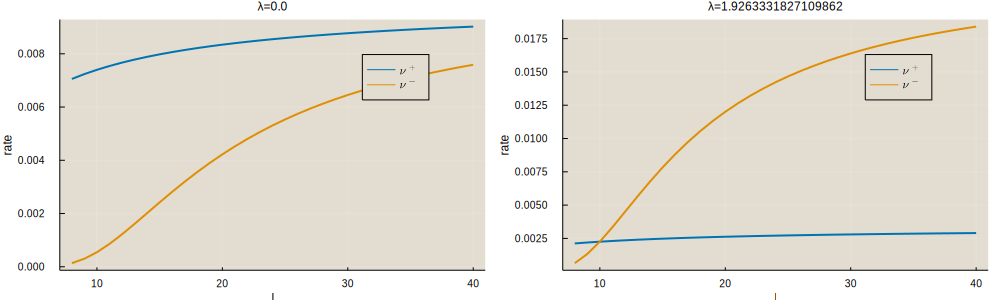

In [18]:
l = collect(8:40)
p_list = []
for F in [F0, F]

    up, down = length_rates(κ, F, n)


    p = plot(
        l, 
        up, 
        label=L"$\nu^+$",
        ylabel="rate",
        xlabel="l",
        linewidth=2,
        color=palette(:seaborn_colorblind)[1],
        title="λ=$(F.fl * 2N)"
    )

    plot!(
        l, 
        down, 
        label=L"$\nu^-$",
        linewidth=2,
        color=palette(:seaborn_colorblind)[2],
    )
    push!(p_list, p)
end
plot(p_list..., size=(1000, 300))

### Marginal Length distribution

From the rates, we can compute a marginal length distribution, assuming detailed balance, which we can do due to the separation of time scales. Let's first look at the distribution for the initial fitness cost for length.

In [19]:
function p_length(κ::Real, F::Jevo.fitness_functions, n::Int64, l::Array{Int, 1})
    up, down = length_rates(κ, F, n, l)
    p_l = zeros(length(up))
    p_l[1] = 0.1

    # detailed balance
    for i in 2:length(up)
        p_l[i] = p_l[i-1] * up[i-1] / down[i]
    end

    # normalize
    p_l /= sum(p_l)
    return p_l
end

p_length (generic function with 1 method)

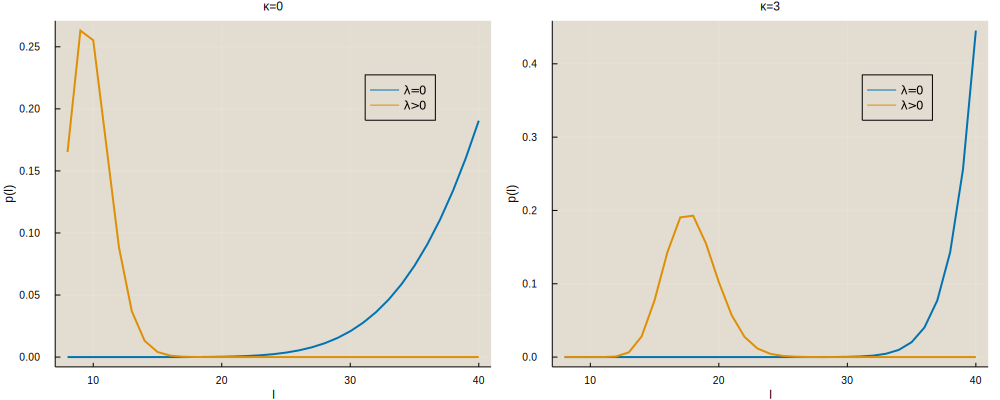

In [21]:
p_1 = plot(8:40, p_length(0, F0, n, collect(8:40)), title="κ=0", xlabel="l", ylabel="p(l)", linewidth=2, label="λ=0")
plot!(p_1, 8:40, p_length(0, F, n, collect(8:40)), linewidth=2, label="λ>0")

p_2 = plot(8:40, p_length(3, F0, n, collect(8:40)), title="κ=3", xlabel="l", ylabel="p(l)", linewidth=2, label="λ=0")
plot!(p_2, 8:40, p_length(3, F, n, collect(8:40)), linewidth=2, label="λ>0")
plot(p_1, p_2, size=(1000, 400))

We see that the distribution is peaked around values much higher than the predicted length from the genetic load observation, which was around $l=10$ for these values. Let's have a look at how this distribution behaves with increased non-equilibrium.

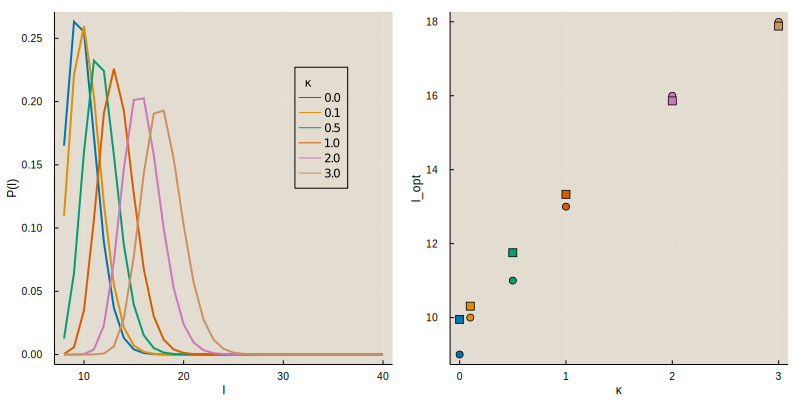

In [22]:
p_left = plot(xlabel="l", ylabel="P(l)",legendtitle="κ")
p_right = plot(xlabel="κ", ylabel="l_opt")

for (i, κ) in enumerate([0, 0.1, 0.5, 1, 2, 3])
    p_l = p_length(κ, F, n, collect(8:40))
    color = palette(:seaborn_colorblind)[i]
    scatter!(p_right, [κ, κ], [argmax(p_l) + 7, sum(p_l .* collect(8:40))], shape=[:circle, :rect], color=color)
    plot!(p_left, 8:40, p_l, linewidth=2, label="$κ", color=color)
end

plot(p_left, p_right, size=(800, 400))

In [31]:
p_arr = []
for ϵ in [1, 1.5, 2, 2.5, 3]
    for f0 in [50, 100, 200, 500] ./ 2N
        F = Jevo.fermi_fitness(f0=f0, epsilon=ϵ)
        F.fl = lambda_new(10, n, F)/(2N*l0(n, F))
        l_opt_arr = []
        for κ in 0:0.1:3
            p_l = p_length(κ, F, n, collect(8:40))
            push!(l_opt_arr, argmax(p_l) + 7)
        end
        
        p = plot(
            0.:0.1:3, 
            l_opt_arr, 
            xlabel=L"$\kappa$", 
            ylabel=L"$l_\mathrm{opt}$",
            labelfontsize=10
        )
        x = 0.:0.1:3 |> collect
        
        plot!(
            p, 
            x, 
            [l_opt_dynamic(κ, n, F) for κ in x], 
            color="gray", 
            title=("2Nf0 = $(2N * f0), ϵ=$ϵ \n $(2N*f0*ϵ)"), 
            titlefontsize=10,
            xformatter=x->latexstring("$x"),
            yformatter=x->latexstring("$x"),
            tickfontsize=8
        )
        push!(p_arr, p)
    end
end
        

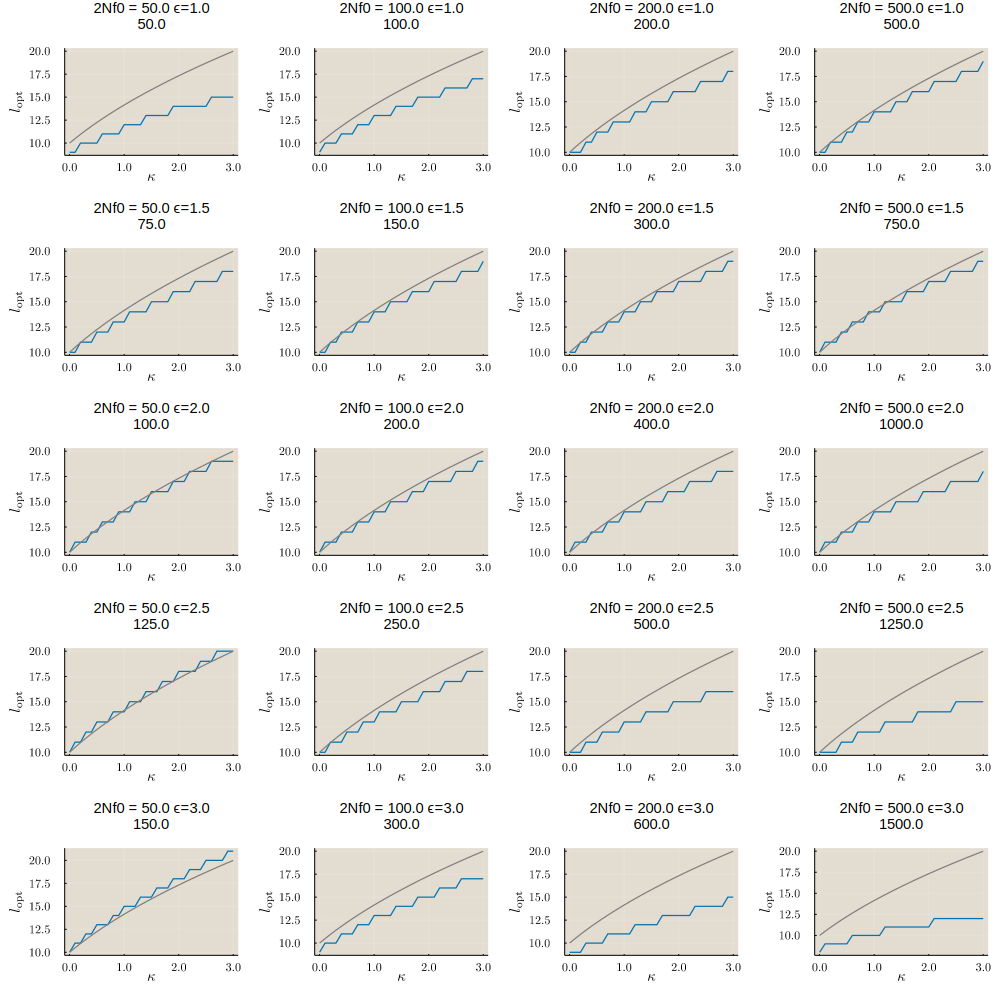

In [32]:
plot(p_arr..., layout=(5,4), size=(1000, 1000))

In [57]:
[(50, 2.5), (100, 2), (200, 1.5), (500, 1)]

4-element Array{Tuple{Int64,Real},1}:
 (50, 2.5)
 (100, 2)
 (500, 1)
 (500, 3)

In [125]:
df_list = []
Metadata_list = []
for name in readdir("../outputs")
    if occursin("2020_12_19_sub", name) 
        if occursin("csv", name)
            push!(df_list, CSV.read("../outputs/" * name, DataFrame))
        elseif occursin("txt", name)
            push!(Metadata_list, Jevo.parse_metadata("../outputs/" * name))
        end
    end
end

In [141]:
p_list = []
F = Jevo.fermi_fitness()
for i in eachindex(df_list)
    cdf = combine(groupby(df_list[i], "rho"), [:l] =>((x) -> (l_mean=mean(x), l_std=std(x))) =>
               AsTable)
    parameters = Metadata_list[i]
    f0 = parse(Float64, parameters["f0"])
    ϵ = parse(Float64, split(parameters["epsilon"], "n")[1])
    n =  20
    fl = lambda_new(10, ϵ, n,f0)/(2N*l0(ϵ, n, f0))
    F.f0 = f0
    F.fl = fl
    F.epsilon = ϵ

    l_opt_arr = []
    for κ in 0:0.01:3
        p_l = p_length(κ, F, ϵ, n, collect(8:80))
        push!(l_opt_arr, argmax(p_l) + 7)
    end
    p = plot(
        0:0.01:3, 
        [l_opt_dynamic(κ, ϵ, n, f0) for κ in (collect(0:0.01:3))],
        xlabel=L"$\kappa$", 
        ylabel=L"$l_\mathrm{opt}$",
        tickfontsize=10,
        xformatter=x->latexstring("$x"),
        yformatter=x->latexstring("$x"),
        linewidth=2,
        title="2Nf_0=$(f0*2N), epsilon= $(ϵ)",
        titlefontsize=12,
        labelfontsize=12,
    )

    plot!(
        p,
        0:0.01:3,
        l_opt_arr)
    

    scatter!(
        p,
        cdf.rho, 
        cdf.l_mean, 
        yerror=cdf.l_std, 
        color=palette(:seaborn_colorblind)[2], 
        markerstrokecolor="black",#palette(:seaborn_colorblind)[2],
        linewidth=1
    )
    push!(p_list, p)
    
end

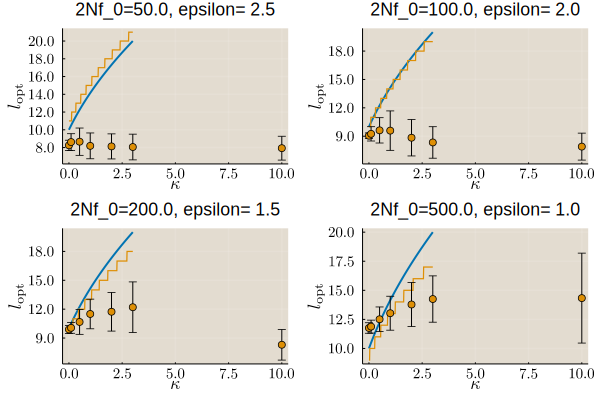

In [142]:
plot(p_list...)

In [144]:
p_list = []
F = Jevo.fermi_fitness()
for i in eachindex(df_list)
    cdf = combine(groupby(df_list[i], [:l, :rho]), nrow)
    parameters = Metadata_list[i]
    f0 = parse(Float64, parameters["f0"])
    ϵ =parse(Float64, split(parameters["epsilon"], "n")[1])
    n = 20
    fl = lambda_new(10, ϵ, n,f0)/(2N*l0(ϵ, n, f0))
    F.f0 = f0
    F.fl = fl
    rho = eval(Meta.parse(parameters["rho"]))
    F.epsilon = ϵ

    l_opt_arr = []
    sub_p = []
    for κ in rho
        p_l = p_length(κ, F, ϵ, n, collect(8:30))
        p = plot(8:30, p_l, linewidth=2)
        scatter!(p, cdf[cdf.rho .== κ, :l], cdf[cdf.rho .== κ, :nrow] ./ sum(cdf[cdf.rho .== κ, :nrow]), title="f0=$(2N*f0), epsilon=$(ϵ), kappa=$(κ)")
        push!(sub_p, p)
        
    end
    push!(p_list, sub_p...)

end

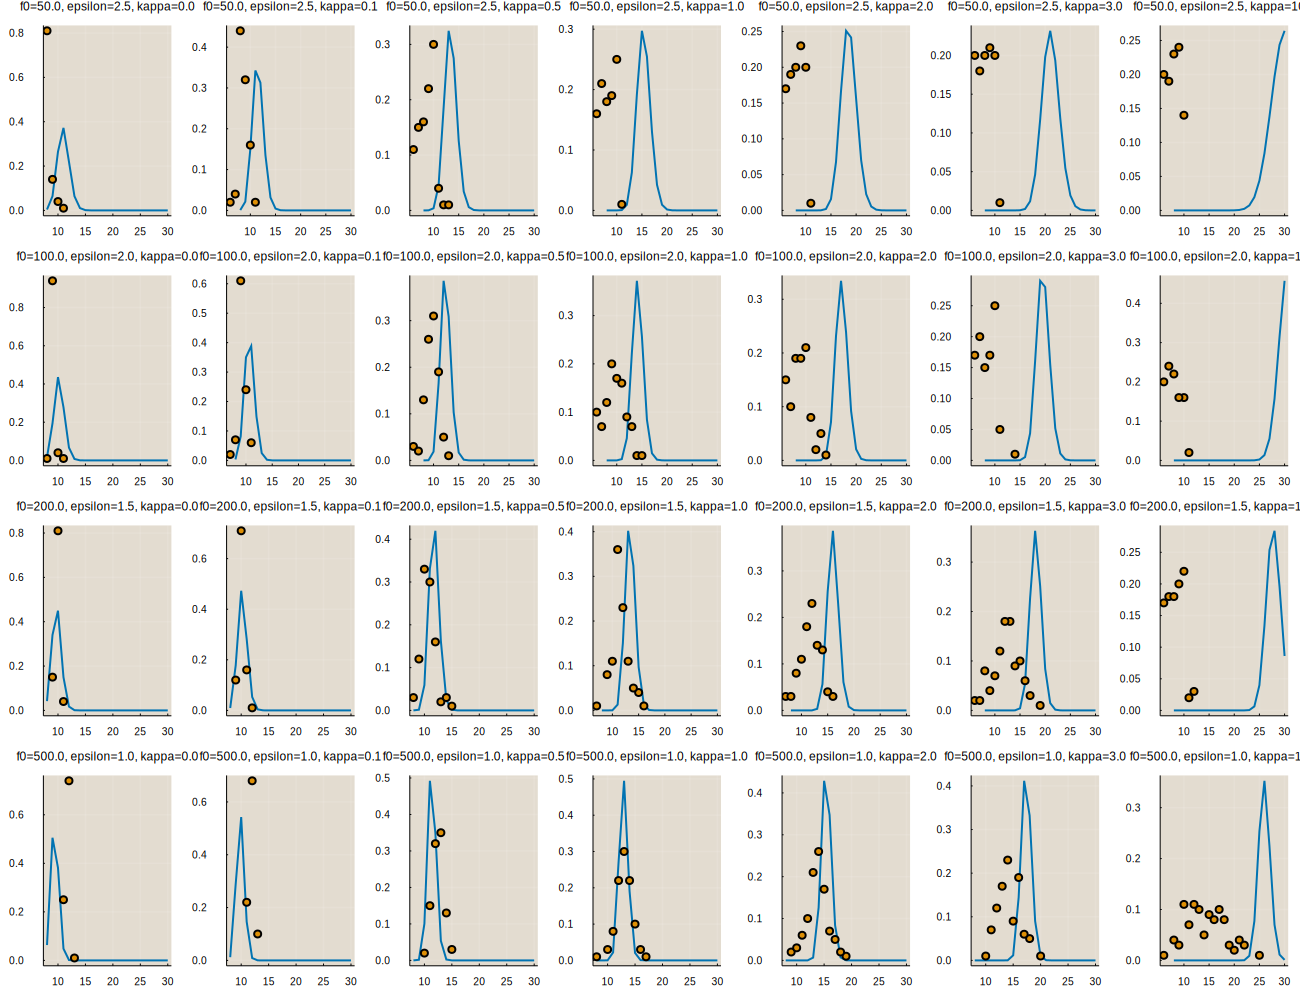

In [145]:
plot(p_list..., size=(1300, 1000), layout=(4, 7))

## Comparing to data

f_0 = 0.25

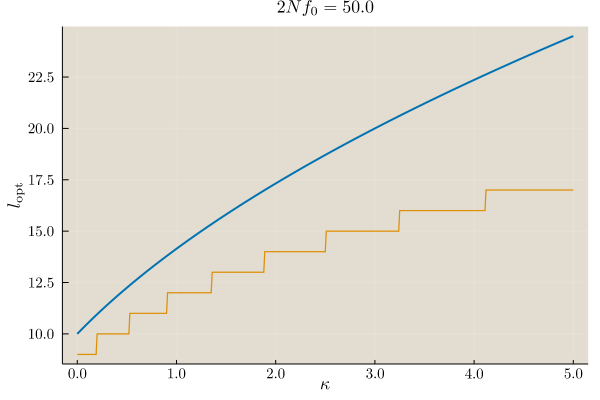

In [26]:
df1 = CSV.read("../outputs/2020_12_10_supp5_script_0.csv", DataFrame)
cdf1 = combine(groupby(df1, "rho"), [:l] =>((x) -> (l_mean=mean(x), l_std=std(x))) =>
               AsTable)
parameters1 = Jevo.parse_metadata("../outputs/2020_12_10_supp5_script_METADATA_0.txt")
print("f_0 = $(parameters1["f0"])")

f0 = parse(Float64, parameters1["f0"])
F.f0 = f0
F.fl = lambda_new(10)/(2N*l0())

l_opt_arr1 = []
for κ in 0:0.01:5
    p_l = p_length(κ, F, collect(8:80))
    push!(l_opt_arr1, argmax(p_l) + 7)
end
p1 = plot(
    0:0.01:5, 
    [l_opt_dynamic(κ) for κ in (collect(0:0.01:5))],
    xlabel=L"$\kappa$", 
    ylabel=L"$l_\mathrm{opt}$",
    tickfontsize=10,
    xformatter=x->latexstring("$x"),
    yformatter=x->latexstring("$x"),
    linewidth=2,
    title=latexstring("2Nf_0=", "$(f0*2N)"),
    titlefontsize=12,
    labelfontsize=12,
)

plot!(
    p1,
    0:0.01:5,
    l_opt_arr1)
#=

scatter!(
    p1,
    cdf1.rho, 
    cdf1.l_mean, 
    yerror=cdf1.l_std, 
    color=palette(:seaborn_colorblind)[2], 
    markerstrokecolor="black",#palette(:seaborn_colorblind)[2],
    linewidth=1
)
=#

f_0 = 1.5

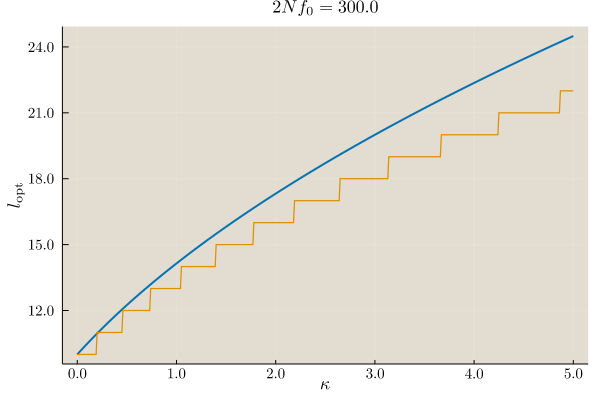

In [27]:
df2 = CSV.read("../outputs/2020_12_10_supp5_script_1.csv", DataFrame)
cdf2 = combine(groupby(df2, "rho"), [:l] =>((x) -> (l_mean=mean(x), l_std=std(x))) =>
               AsTable)
parameters2 = Jevo.parse_metadata("../outputs/2020_12_10_supp5_script_METADATA_1.txt")
print("f_0 = $(parameters2["f0"] )")

f0 = parse(Float64, parameters2["f0"])
F.f0 = f0
F.fl = lambda_new(10)/(2N*l0())

l_opt_arr2 = []
for κ in 0:0.01:5
    p_l = p_length(κ, F, collect(8:80))
    push!(l_opt_arr2, argmax(p_l) + 7)
end
p2 = plot(
    0:0.01:5, 
    [l_opt_dynamic(κ) for κ in (collect(0:0.01:5))],
    xlabel=L"$\kappa$", 
    ylabel=L"$l_\mathrm{opt}$",
    tickfontsize=10,
    xformatter=x->latexstring("$x"),
    yformatter=x->latexstring("$x"),
    linewidth=2,
    title=latexstring("2Nf_0=", "$(f0*2N)"),
    titlefontsize=12,
    labelfontsize=12,
)

plot!(
    p2,
    0:0.01:5,
    l_opt_arr2)
#=
scatter!(
    p3,
    cdf3.rho, 
    cdf3.l_mean, 
    yerror=cdf3.l_std, 
    color=palette(:seaborn_colorblind)[2], 
    markerstrokecolor="black",#palette(:seaborn_colorblind)[2],
    linewidth=1,
)
=#

3.0

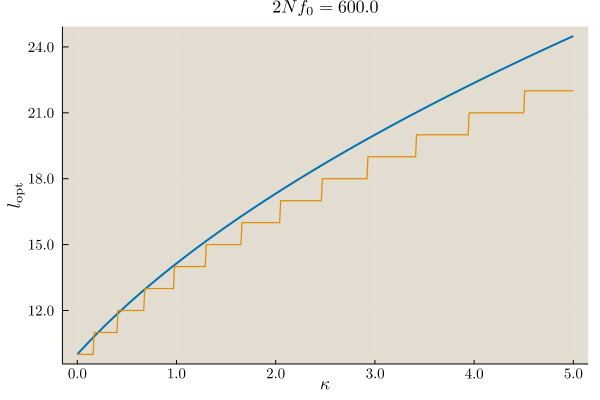

In [28]:
df3 = CSV.read("../outputs/2020_12_10_supp5_script.csv", DataFrame)
cdf3 = combine(groupby(df3, "rho"), [:l] =>((x) -> (l_mean=mean(x), l_std=std(x))) =>
               AsTable)
parameters3 = Jevo.parse_metadata("../outputs/2020_12_10_supp5_script_METADATA.txt")
print(parameters3["f0"])

f0 = parse(Float64, parameters3["f0"])
F.f0 = f0
F.fl = lambda_new(10)/(2N*l0())

l_opt_arr3 = []
for κ in 0:0.01:5
    p_l = p_length(κ, F, collect(8:80))
    push!(l_opt_arr3, argmax(p_l) + 7)
end
p3 = plot(
    0:0.01:5, 
    [l_opt_dynamic(κ) for κ in (collect(0:0.01:5))],
    xlabel=L"$\kappa$", 
    ylabel=L"$l_\mathrm{opt}$",
    tickfontsize=10,
    xformatter=x->latexstring("$x"),
    yformatter=x->latexstring("$x"),
    linewidth=2,
    title=latexstring("2Nf_0=", "$(f0*2N)"),
    titlefontsize=12,
    labelfontsize=12,
)

plot!(
    p3,
    0:0.01:5,
    l_opt_arr3)
#=
scatter!(
    p2,
    cdf2.rho, 
    cdf2.l_mean, 
    yerror=cdf2.l_std, 
    color=palette(:seaborn_colorblind)[2], 
    markerstrokecolor="black",#palette(:seaborn_colorblind)[2],
    linewidth=1,
)=#

Now we can reconstruct the join probabiliy $Q(\Gamma,l)$ by multiplying the marginal length distribution to the conditional distrbution for binding energies at given lengths.

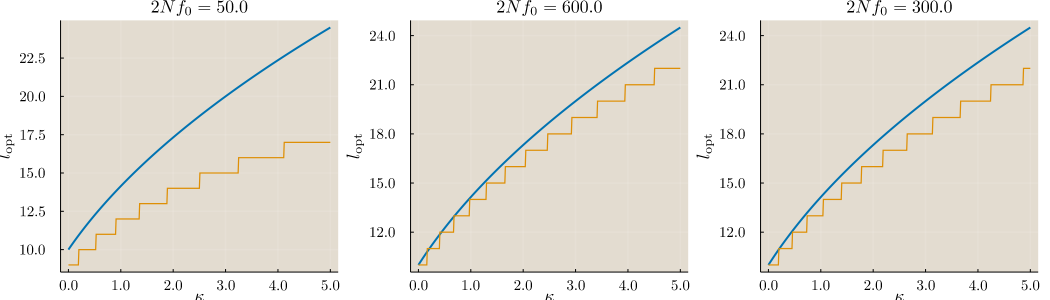

In [29]:
p4 = plot([p1, p3, p2]..., layout=(1, 3), size=(1050, 300))

In [268]:
#savefig(p4, "../figures/optim_l_dynamic_with_sim.pdf")